## NNCL ASSIGNMENT 3

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Epoch: 0, Error: 0.8498231368018208, Test Error: 0.5343652336343504
Epoch: 1, Error: 0.5065476821662622, Test Error: 0.40654485612568464
Epoch: 2, Error: 0.37466074128482885, Test Error: 0.3414115486652643
Epoch: 3, Error: 0.2801414637717377, Test Error: 0.249292530485369
Epoch: 4, Error: 0.1661702349462027, Test Error: 0.20691582924746363
Epoch: 5, Error: 0.12658174641942813, Test Error: 0.1672406790499474
Epoch: 6, Error: 0.10713479584303118, Test Error: 0.17796994983635386
Epoch: 7, Error: 0.10385765285410013, Test Error: 0.17145350020047906
Epoch: 8, Error: 0.09539657599877098, Test Error: 0.17270128039554655
Epoch: 9, Error: 0.0920846043188027, Test Error: 0.19823620352352866
Epoch: 10, Error: 0.09240790058606912, Test Error: 0.16901884665413372
Epoch: 11, Error: 0.08904285587949183, Test Error: 0.17138319766095825
Epoch: 12, Error: 0.08723116232886356, Test Error: 0.18526681958247973
Epoch: 13, Error: 0.08716095486971236, Test Error: 0.18412449640566078
Epoch: 14, Error: 0.085125

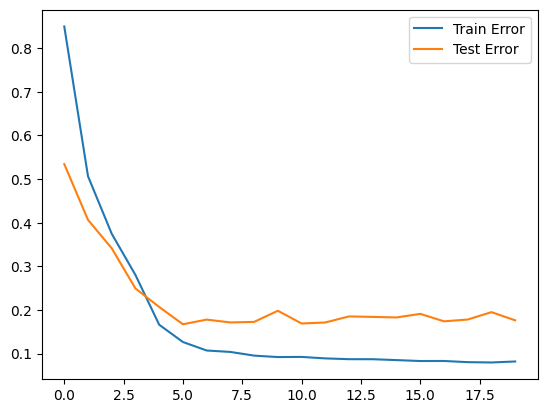

In [147]:
class Network:
    def __init__(self, P, Q, N, K, learning_rate):
        # P = amount of input samples
        self.P = P
        # Q = amount of test samples
        self.Q = Q
        # N = amount of neurons in the input layer
        self.N = N
        # K = amount of neurons in the hidden layer
        self.K = K
        # eta = learning rate
        self.eta = learning_rate
        # W = weights form input to hidden layers
        self.W = self.initWeights()
        # V = weights from hidden layer to output, fixed to 1
        self.V = np.ones((1, self.K))

    def initWeights(self):
        # Generate random vectors and normalize each vector to have a norm of 1
        weights = np.random.randn(self.N, self.K)
        norms_squared = np.linalg.norm(weights, axis=1, keepdims=True) ** 2
        normalized_weights = weights / norms_squared

        return normalized_weights

    def forwardPass(self, x):
        """
        Tanh activation function.
        """

        # Calculate the dot product of the first-layer weights and the input.
        dot_product = np.zeros(self.K)
        for i in range(self.K):
            dot_product[i] = np.dot(self.W[:, i], x)
        # Apply hyperbolic tangent element-wise and sum for sigma.
        tanh_result = np.tanh(dot_product)
        sigma = np.sum(self.V * tanh_result)

        # Sigma is the output of the network for a given input x
        return sigma

    def stochasticGradientDescent(self, sigma, xi, tau):
        """
        Stochastic gradient descent
        """
        # Use the gradient with respect to its contribution to the error
        for i in range(self.K):
            gradient = (sigma - tau) * (1 - np.tanh(np.dot(self.W[:, i], xi)) ** 2)
            # Update the weights
            self.W[:, i] = self.W[:, i] - self.eta * gradient * xi

    def calculateError(self, sigma, tau):
        # Error is the quadratic difference between sigma (network output) and
        # tau (target value)
        return ((sigma - tau) ** 2) / 2

    def train(self, t_max, train_set, test_set):
        """
        Train the network using stochastic gradient descent.
        """
        # Select a random sample from the train_set, and perform a forward pass.
        # Then, update the weights using the SGD algorithm.
        # Run for t_max * P iterations.
        # Select a random sample from the train_set, make sure that for each t,
        # all samples are used, but in random order.
        train_err = []
        test_err = []
        for epoch in range(t_max):
            # For each epoch, keep track of the error and print the average
            # error for the epoch.
            epoch_error = 0
            epoch_error_test = 0
            for index in np.random.permutation(self.P):
                xi, tau = train_set[index]
                sigma = self.forwardPass(xi)
                epoch_error += self.calculateError(sigma, tau)
                self.stochasticGradientDescent(sigma, xi, tau)
            epoch_error /= self.P

            for index in np.random.permutation(self.Q):
                xi, tau = test_set[index]
                sigma = self.forwardPass(xi)
                epoch_error_test += self.calculateError(sigma, tau)
            epoch_error_test /= self.Q

            train_err.append(epoch_error)
            test_err.append(epoch_error_test)

            print(
                f"Epoch: {epoch}, Error: {epoch_error.item()}, Test Error: {epoch_error_test.item()}"
            )

        return train_err, test_err


# Inputs
xi = pd.read_csv("data/xi.csv", delimiter=",", header=None)
tau = pd.read_csv("data/tau.csv", delimiter=",", header=None)

# Take a column from each dataset and combine them into a (feature, label) tuple without
# using zip.
dataset = [(xi.iloc[:, i], tau.iloc[:, i][0]) for i in range(5000)]

# P = amount of input samples
P = 400
# Q = amount of test samples
Q = 100
# N = input dimensionality
N = 50
# K = amount of neurons in the hidden layer
K = 2

# Take only the first 100 samples
train_set = dataset[:P]
test_set = dataset[P:P+Q]

network = Network(P=P, Q=Q, N=N, K=K, learning_rate=0.05)
train_err, test_err = network.train(t_max=20, train_set=train_set, test_set=test_set)

# Plot the error
plt.plot(train_err, label="Train Error")
plt.plot(test_err, label="Test Error")
plt.legend()
plt.show()


In [ ]:
# Use the gradient with respect to its contribution to the error
for i in range(self.K):
    gradient = (sigma - tau) * (1 - np.tanh(np.dot(self.W[:, i], xi)) ** 2)
    # Update the weights
    self.W[:, i] = self.W[:, i] - self.eta * gradient * xi

In [ ]:
# Use the gradient with respect to its contribution to the error
for i in range(self.K):
    gradient = (sigma - tau) * (1 - np.tanh(np.dot(self.W[:, i], xi)) ** 2)
    # Update the weights
    self.W[:, i] = self.W[:, i] - self.eta * gradient * xi